In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Calibration
## Preparation of input data
Synthesise LoS columns with optimal paths from the model

In [28]:
input_path = '../input/transport_demand/'
zone_data_path = '../input_static/zones_Gebietsaenderungen/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
# Load StepModel with LOS table from base scenario
sm = stepmodel.read_json(model_path + 'base/' + 'de_pt_access_egress')
pt = stepmodel.read_json(model_path + 'base/' + 'de_pt_los')
car = stepmodel.read_json(model_path + 'base/' + 'de_road_los')

In [7]:
sm.pt_los = pt.pt_los
sm.car_los = car.car_los

In [119]:
# Reset route types
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)
sm.pt_los['route_type'].unique()

array(['bus', 'rail_long', 'rail_short', 'coach', 'air', 'walk'],
      dtype=object)

In [9]:
# Load calibration dataset
trips = pd.read_csv(input_path + 'calibration_all_trips_MiD2017.csv', index_col='Unnamed: 0')
trips.reset_index(inplace=True, drop=True)
len(trips.index)

320007

In [10]:
# Filter for inter-zonal traffic
trips = trips.loc[trips['origin']!=trips['destination']]
# Filter for longer trips (taking routed distance)
trips = trips.loc[trips['distance_routed']>4]
trips.shape

(146820, 34)

In [85]:
# Load official data sources that describe changes
# in ARS codes within one year (Gebietsänderungen)
col_names = ['n', 'level', 'old_ARS', 'old_AGS', 'old_name',
             'change', 'area', 'population', 'new_ARS', 'new_AGS',
             'new_name', 'date1', 'date2']
def update_ARS_until(end, ars):
    for year in range(2016, end+1):
        changes = pd.read_excel(zone_data_path + str(year) + '.xlsx',
                                sheet_name='Gebietsaenderungen {}'.format(year),
                                header=6, skipfooter=8, index_col=None,
                                names=col_names, na_filter=False)
        changes = changes.loc[(changes['level']=='Gemeindeverband')
                              & (changes['old_ARS']!=changes['new_ARS'])]
        changes['old_ARS'] = changes['old_ARS'].astype(int)
        changes['new_ARS'] = changes['new_ARS'].astype(int)
        update_dict = changes.set_index('old_ARS')['new_ARS'].to_dict()
        ars = ars.replace(update_dict)
    return ars

In [92]:
# Replace LAU codes with NUTS IDs
if not str(trips.loc[0, 'origin']).startswith('DE'):
    # First, update LAU IDs
    trips['origin'] = update_ARS_until(2021, trips['origin'])
    trips['destination'] = update_ARS_until(2021, trips['destination'])
    # Then replace with model's zone IDs
    z = stepmodel.read_json(model_path + 'base/' + 'de_zones')
    lau_dict = z.zones[['FID', 'ARS']].explode('ARS').set_index('ARS')['FID'].to_dict()
    trips['origin'] = trips['origin'].map(lau_dict)
    trips['destination'] = trips['destination'].map(lau_dict)

    # Drop all other trips and trips within zones
    trips = trips.loc[trips['origin']!=trips['destination']]
    trips = trips.loc[(trips['origin'].notna()) & (trips['destination'].notna())]
    print(len(trips.index))

146739


In [93]:
assert len(trips.loc[trips.isna().any(axis=1)])==0

In [94]:
len(trips['origin'].unique())

1955

## Distance
As survey responds regarding trip distance are not accurate, add the network model's length.

In [95]:
# Add a length column based on the shortest
# road connection in the network model (in km)
car_len = sm.car_los.groupby(['origin', 'destination'])['length'].min().to_dict()
trips['length'] = [car_len[a]/1000 if a in car_len.keys() else np.nan
                   for a in tuple(zip(trips['origin'], trips['destination']))]

In [100]:
# Some OD pairs might not be in the volumes table
# which results in missing values for the calibration dataset
k = len(trips.loc[trips['length'].isna()])
k / len(trips)

0.00031194990975734753

In [101]:
# Drop trips without time reference if its share is insignificant
assert k/len(trips)<0.01, 'Too many connections missing in the model'
trips = trips.loc[trips['length'].notna()]

<AxesSubplot:xlabel='length', ylabel='distance'>

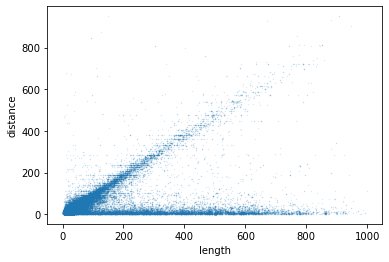

In [102]:
# Comparison of the model's length and the survey's distance
trips.plot.scatter(x='length', y='distance', s=.1, alpha=.2)

In [103]:
# Number of observations without routed distance
len(trips.loc[trips['distance_routed']>9])

5511

In [104]:
# We can validate it with the routed distances from MiD.
# in MiD: bins = [0, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000]
# in MiD: labels = [1,2,3,4,5,6,7,8,9]
bins = [0, 50, 100, 1000]
labels = [1,2,3]
label_dict = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:2, 9:3}
trips['length_routed'] = pd.cut(trips['length'], bins=bins, labels=labels)
# How many trips have mismatching routed distances?
len(trips.loc[(trips['distance_routed'].map(label_dict)!=trips['length_routed'])&
              (trips['distance_routed']<=9)])

7990

In [105]:
# Check the routed distance in the calibration dataset
trips['distance_routed_2'] = pd.cut(trips['distance'], bins=bins, labels=labels)
# How many trips have mismatching routed distances? Is it all nonsense?
len(trips.loc[(trips['distance_routed'].map(label_dict)!=trips['distance_routed_2'])&
              (trips['distance_routed']<=9)])

13946

<AxesSubplot:xlabel='mode_model'>

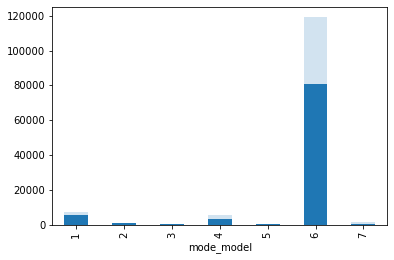

In [106]:
# Number of observations where the distance is far from the network model
trips['dist_diff'] = np.abs(trips['length']-trips['distance'])
trips['dist_diff'] = trips['dist_diff']<trips['length']*0.5
trips.groupby('mode_model')['dist_diff'].sum().plot.bar(
    ax=trips.groupby('mode_model').count()['origin'].plot.bar(alpha=.2))

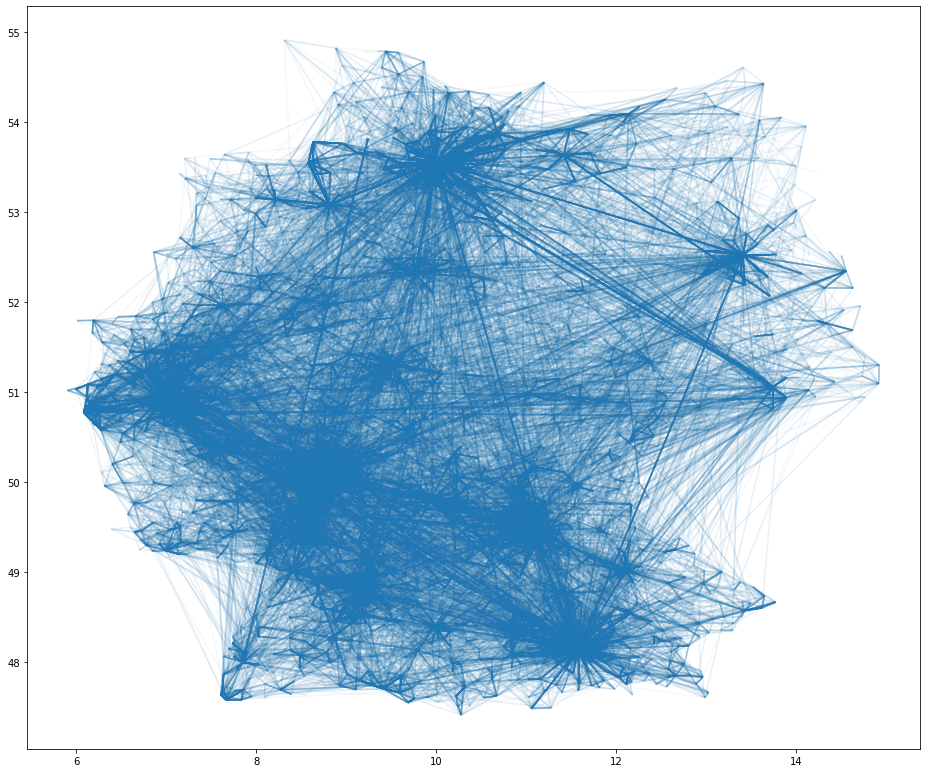

In [107]:
# Locations of observations
if manual:
    from shapely import geometry
    geo_dict = sm.centroids['geometry'].to_dict()
    gdf = gpd.GeoDataFrame(trips[['origin', 'destination']],
                           geometry=[geometry.LineString([geo_dict[o].coords[0],
                                                          geo_dict[d].coords[0]])
                                     for o,d in trips[['origin', 'destination']].values])
    gdf.plot(alpha=.05, figsize=(16,16))

## Time

All imputated time columns are needed for the MLE model. They do not replace duration statements in the survey but complement each trip with alternative travel times in modes that were not used for this trip.

In [108]:
# IMPORTANT: Make sure pt_los time is converted to minutes
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 60
elif sm.pt_los['time'].mean() < 10:
    sm.pt_los['time'] = sm.pt_los['time'] * 60
sm.pt_los['time'].mean()

382.36247976973743

In [109]:
# IMPORTANT: Make sure car_los time is converted to minutes
if sm.car_los['time'].mean() > 3600:
    sm.car_los['time'] = sm.car_los['time'] / 60
elif sm.car_los['time'].mean() < 10:
    sm.car_los['time'] = sm.car_los['time'] * 60
sm.car_los['time'].mean()

253.96584344428845

In [120]:
# Create dictionaries from LoS tables
# Take the mean of 2 fastest trips for PT
car_dict = sm.car_los.groupby(['origin', 'destination'])['time'].min().to_dict()
pt_dict = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_type']).nth([0,1]).groupby(
    ['origin', 'destination', 'route_type']).agg({'time': 'mean'}).to_dict()['time']

In [111]:
# Car
# Directly from car LoS table
trips['time_car'] = [car_dict[a] if a in car_dict.keys() else np.nan
                     for a in tuple(zip(trips['origin'], trips['destination']))]
assert len(trips.loc[trips['time_car'].isna()])==0

In [121]:
# PT (incl. bicycle)
for t in sm.pt_los['route_type'].unique():
    trips['route_type'] = t
    trips['time_' + t] = [pt_dict[a]
        if a in pt_dict.keys() else np.inf
        for a in tuple(zip(trips['origin'], trips['destination'], trips['route_type']))]
trips.drop('route_type', axis=1, inplace=True)

### Waiting time

Include waiting time (half the PT trip's headway), in case it becomes a calibration parameter.

In [122]:
# Take waiting times from the two fastest model connection
wait_time_dict = sm.pt_los.sort_values('waiting_time').groupby(
    ['origin', 'destination', 'route_type']).nth([0,1]).groupby(
    ['origin', 'destination', 'route_type']).agg(
    {'waiting_time': 'mean'}).to_dict()['waiting_time']

In [123]:
for t in sm.pt_los['route_type'].unique():
    trips['route_type'] = t
    trips['waiting_time_' + t] = [wait_time_dict[a]
        if a in wait_time_dict.keys() else np.inf
        for a in tuple(zip(trips['origin'], trips['destination'], trips['route_type']))]
trips.drop('route_type', axis=1, inplace=True)

## Validation of model connectivity

The network model might not provide paths between all OD pairs for all modes. Moreover, the survey might contain erronous statements about trip distance, duration or even origin and destination cell.

In [115]:
# Drop trips where speeds are unrealistic
max_speeds = {1: 150, 2: 200, 3: 50, 4: 100, 5: 1000, 6: 150, 7: 30}
for mode, max_speed in max_speeds.items():
    mask = (trips['mode_model']==mode)&((trips['length']/trips['duration'])>max_speed)
    if manual: print('{}: dropped {} observations ({} %)'.format(
        mode, len(trips.loc[mask]), len(trips.loc[mask])/len(trips.loc[trips['mode_model']==mode])*100))
    trips = trips.loc[~(mask)]

1: dropped 0 observations (0.0 %)
2: dropped 0 observations (0.0 %)
3: dropped 0 observations (0.0 %)
4: dropped 0 observations (0.0 %)
5: dropped 0 observations (0.0 %)
6: dropped 10 observations (0.008401172803723399 %)
7: dropped 45 observations (3.557312252964427 %)


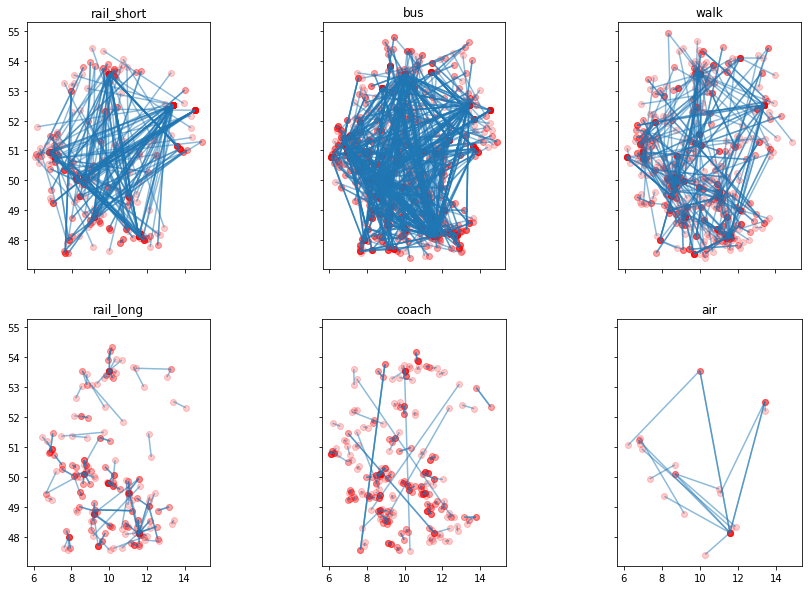

In [124]:
# Check observations without model connection
mode_dict = {1: 'rail_short', 2: 'rail_long',
             3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
fix, axs = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all', figsize=(15,10))
for m, row, col in [(1,0,0), (2,1,0), (3,1,1), (4,0,1), (5,1,2), (7,0,2)]:
    t = trips.loc[((trips['mode_model']==m) & (trips['time_'+mode_dict[m]]==np.inf))]
    lines = gpd.GeoDataFrame({'mode': [m]*len(t),
                              'geometry': [geometry.LineString([sm.centroids.loc[o, 'geometry'].coords[0],
                                                                sm.centroids.loc[d, 'geometry'].coords[0]])
                                           for o,d in zip(t['origin'], t['destination'])]},
                             crs=sm.epsg)
    lines.plot(alpha=.5, ax=gpd.GeoDataFrame(sm.centroids,crs=sm.epsg).loc[
        list(t['origin'])+list(t['destination']), 'geometry'].plot(
            alpha=.2, color='red', ax=axs[row,col]))
    axs[row,col].set_title(mode_dict[m])

In [125]:
# Aggregate rail: Take the alternative with lower duration,
# if the chosen mode is not rail (then take the corresponding value)
trips['time_rail'] = np.inf
# Fill in observations for short-distance below distance threshold
mask = (trips['mode_model']==1)&(trips['length']<params['clean_los']['max_dist_rail_short']/1000)
trips.loc[mask, 'time_rail'] = np.minimum(trips.loc[mask, 'time_rail_short'],
                                          trips.loc[mask, 'time_rail'])
# Observations for long-distance
mask = (trips['mode_model']==2)
trips.loc[mask, 'time_rail'] = np.minimum(trips.loc[mask, 'time_rail_long'],
                                          trips.loc[mask, 'time_rail'])
# Replace missing values with the other alternative (also above threshold)
mask = (trips['mode_model'].isin([1,2]))&(trips['time_rail']==np.inf)
trips.loc[mask, 'time_rail'] = np.minimum(trips.loc[mask, 'time_rail_long'],
                                          trips.loc[mask, 'time_rail_short'])
# For other observed modes, take the minimum time
mask = ~(trips['mode_model'].isin([1,2]))
trips.loc[mask, 'time_rail'] = np.minimum(trips.loc[mask, 'time_rail_long'],
                                          trips.loc[mask, 'time_rail_short'])

In [126]:
# Aggregate road PT
# Statements of mode choice don't make much sense, so don't
# take the time of the reported mode
trips['time_road'] = np.inf
# Take local bus times up to a distance threshold
mask = trips['length']<params['clean_los']['max_dist_bus']/1000
trips.loc[mask, 'time_road'] = trips.loc[mask, 'time_bus']
# Take coach times from a minimum distance, if available
mask = trips['length']>params['clean_los']['min_dist_coach']/1000
trips.loc[mask, 'time_road'] = np.minimum(trips.loc[mask, 'time_coach'],
                                          trips.loc[mask, 'time_road'])

In [127]:
# Mean distance of not assigned road PT trips
trips.loc[((trips['mode_model'].isin([3,4])) & (trips['time_road']==np.inf)), 'length'].mean()

204.41001254480247

In [128]:
# How many observations have no connection?
m_dict = {v:k for k,v in mode_dict.items()}
for t in m_dict.keys():
    try:
        k = len(trips.loc[((trips['mode_model']==m_dict[t]) & (trips['time_'+t]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            t, k, k/len(trips.loc[trips['mode_model']==m_dict[t]])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(t))

rail_short: 366 observations have no model connection (5.136121246140893 percent)
rail_long: 156 observations have no model connection (14.538676607642126 percent)
coach: 200 observations have no model connection (63.09148264984227 percent)
bus: 1274 observations have no model connection (22.187391152908393 percent)
air: 17 observations have no model connection (41.46341463414634 percent)
car: 0 observations have no model connection (0.0 percent)
walk: 456 observations have no model connection (37.37704918032787 percent)


In [129]:
# How many observations have no connection? (aggregated)
for name, m in {'rail': [1,2], 'road': [3,4], 'air': [5]}.items():
    try:
        k = len(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            name, k, k/len(trips.loc[trips['mode_model'].isin(m)])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(name))

rail: 150 observations have no model connection (1.8294914013904133 percent)
road: 558 observations have no model connection (9.209440501732958 percent)
air: 17 observations have no model connection (41.46341463414634 percent)


In [130]:
# Air trips (should be 42 in order to statistically representative with a sample of 95000 trips)
len(trips.loc[trips['mode_model']==5])

41

In [131]:
# Save missing trips
t = trips.iloc[0:0]
for name, m in [('rail',[1,2]), ('road',[3,4]), ('air',[5])]:
    t = t.append(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
t.to_csv(input_path + 'missing_trips.csv')

In case of public road transport, there might be private charter buses included into the calibration dataset, which cannot be included into the network model. A closer look at missing trips reveals only long-distance travel with purposes shopping or education, which could well be organised shopping trips or class trips, respectively. Thus, we can drop these trips.

If there are only few missing rail connections, this is a bad indicator for network model quality.

Walking/cycling trips are very unreliable in MiD2017. Many of them have erronous origin or destination codes, making them urealistically long. In the network model, there are walking connections of reasonable lengths only, so that we can drop walking observations without model connection.

In [132]:
# Drop missing trips
for name, m in {'rail': [1,2], 'road': [3,4], 'walk': [7]}.items():
    trips = trips.loc[~((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))]
trips.shape

(133376, 54)

In [133]:
# Mean distance of all non-motorised trips
trips.loc[(trips['mode_model']==7), 'length'].mean()

16.094441099476466

In [50]:
# Assign cycling speed
mask = ((trips['mode_model']==7) & (trips['time_walk']==np.inf))
#trips.loc[mask, 'time_walk'] = trips.loc[mask, 'length'] / 17 # km/h

In [135]:
# Replace non-existent air connections with model paths
for ind in trips.loc[(trips['mode_model']==5) & (trips['time_air']==np.inf)].index:
    s = sm.pt_los.loc[sm.pt_los['route_type']=='air'].sample()
    o = s['origin'].values[0]
    d = s['destination'].values[0]
    trips.loc[ind, 'origin'] = o
    trips.loc[ind, 'destination'] = d
    trips.loc[ind, 'urbanisation'] = 2
    trips.loc[ind, 'distance'] = s['length'].values[0] / 1000
    trips.loc[ind, 'length'] = s['length'].values[0] / 1000
    trips.loc[ind, 'duration'] = s['time'].values[0] / 60
    trips.loc[ind, 'time_air'] = s['time'].values[0] / 60
    trips.loc[ind, 'time_car'] = car_dict[(o,d)]
    trips.loc[ind, 'time_walk'] = pt_dict[(o,d,'walk')] if (o,d,'walk') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_short'] = pt_dict[(o,d,'rail_short')] if (o,d,'rail_short') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_long'] = pt_dict[(o,d,'rail_long')] if (o,d,'rail_long') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_bus'] = pt_dict[(o,d,'bus')] if (o,d,'bus') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_coach'] = pt_dict[(o,d,'coach')] if (o,d,'coach') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail'] = min(trips.loc[ind, 'time_rail_short'], trips.loc[ind, 'time_rail_long'])
    trips.loc[ind, 'time_road'] = min(trips.loc[ind, 'time_bus'], trips.loc[ind, 'time_coach'])

In [136]:
trips.replace({np.inf: np.nan}).groupby('mode_model').agg(
    {'time_rail_long': 'mean', 'time_rail_short': 'mean', 'time_rail': 'mean',
     'time_coach': 'mean', 'time_bus': 'mean', 'time_road': 'mean',
     'time_air': 'mean', 'time_car': 'mean', 'time_walk': 'mean'})

,time_rail_long,time_rail_short,time_rail,time_coach,time_bus,time_road,time_air,time_car,time_walk
mode_model,,,,,,,,,
1,96.180588,46.884197,55.442057,234.752751,73.330558,92.066041,338.078522,54.371299,61.140852
2,164.730752,137.909705,152.779428,271.565786,125.392449,251.716954,321.018603,153.507593,70.993056
3,167.180016,84.406550,95.811562,311.837865,61.539539,152.687050,314.016667,86.076132,62.423194
4,158.074836,53.300061,66.227786,344.211674,49.473212,96.785916,366.260398,58.705843,57.618735
5,330.070732,37.583333,330.070732,513.726282,67.683333,514.001282,185.140976,323.587398,NaN
6,166.681823,63.569792,74.418716,314.693551,65.834407,98.632342,383.049830,60.564939,60.647528
7,42.149020,33.333267,33.301991,331.993750,43.210745,43.210745,NaN,30.583726,56.736126


## Price
For model calibration we need cost data for each trip. This column is generated using the travel cost function from the model's LoS formulation. For PT, the type of ticket or subscription is being considered.

In [137]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [138]:
trips['cost_walk'] = 0 # foot and bicycle trips are free of monetary cost

In [140]:
# The same assumptions for car travel as in the car LoS generation (prep30)
vc_car = params['car_var_cost'].to_dict()
fix_car = params['car_fix_cost'].to_dict()
parking_cost = params['parking_cost'].to_dict()
trips['cost_car'] = [monetary_cost(d, 1, vc_car[str(p)+'_car'], 0,0, parking_cost[u], 1, n
                                  ) + fix_car[str(p)+'_car'] * t/60
                     for d, n, u, t, p in zip(trips['length'], trips['n_persons'],
                                              trips['urbanisation'], trips['duration'],
                                              trips['purpose_model'])]

In [141]:
# Ticket type determines the trip cost
# Assume this dict with factors
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}

In [142]:
# Rail short-distance, see prep31
# Trips with subscriptions are free of charge
rail_short_slope = params['rail_short']['slope']
rail_short_intercept = params['rail_short']['intercept']
trips['cost_rail_short'] = [(d*rail_short_slope + rail_short_intercept) * ticket_dict[t]
                            for d, t in zip(trips['length'], trips['ticket_type'])]

In [143]:
# Add price cap
trips['cost_rail_short'] = np.clip(trips['cost_rail_short'],
    0,
    params['rail_short']['max'])

In [151]:
# Rail long-distance
# Take prices from the model (validated)
# Choose the fastest routes as reference
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
rail_dict = sm.pt_los.sort_values('time').loc[
    sm.pt_los['route_type']=='rail_long'
].groupby(['origin', 'destination']).nth([0,1]).groupby(
    ['origin', 'destination']).agg({seg+'_price': 'mean' for seg in segments}).to_dict()
car_str = ['_no_car', '_car']
trips['cost_rail_long'] = [rail_dict[str(p)+car_str[car]+'_price'][(o,d)]
                           if (o,d) in rail_dict[str(p)+car_str[car]+'_price'].keys() else np.inf
                           for o, d, p, car in zip(trips['origin'], trips['destination'],
                                                   trips['purpose_model'], trips['car_avail']==1)]

In [152]:
# Aggregate rail: Take same aggregation as above (shortest time)
trips['cost_rail'] = np.inf
# Fill in observations for short-distance below distance threshold
mask = (trips['mode_model']==1)&(trips['length']<params['clean_los']['max_dist_rail_short']/1000)
trips.loc[mask, 'cost_rail'] = trips.loc[mask, 'cost_rail_short']
# Observations for long-distance
mask = (trips['mode_model']==2)
trips.loc[mask, 'cost_rail'] = trips.loc[mask, 'cost_rail_long']
# Replace missing values with the other alternative (also above threshold)
mask = (trips['mode_model'].isin([1,2]))&(trips['cost_rail']==np.inf)
trips.loc[mask, 'cost_rail'] = np.minimum(trips.loc[mask, 'cost_rail_long'],
                                          trips.loc[mask, 'cost_rail_short'])
# For other observed modes, take the minimum time
mask = ~(trips['mode_model'].isin([1,2]))
trips.loc[mask, 'cost_rail'] = [s if t_s < t_l else l for t_s, t_l, s, l in zip(
    trips.loc[mask, 'time_rail_short'], trips.loc[mask, 'time_rail_long'],
    trips.loc[mask, 'cost_rail_short'], trips.loc[mask, 'cost_rail_long'])]

In [153]:
# Bus and tram
# Trip cost depend on the ticket type and regional type
# See prep31 for prices
region_prices = params['bus'].to_dict()
trips['cost_bus'] = [region_prices[r] * ticket_dict[t]
                     for r,t in zip(trips['urbanisation'], trips['ticket_type'])]

In [154]:
# Coach
# see prep31
trips['cost_coach'] = trips['length'] * params['coach']['slope']
trips['cost_coach'] = np.clip(trips['cost_coach'],
    params['coach']['min'],
    params['coach']['max'])

In [155]:
# Aggregate the same way as for time
trips['cost_road'] = np.inf
# Take local bus prices up to a distance threshold
mask = trips['length']<params['clean_los']['max_dist_bus']/1000
trips.loc[mask, 'cost_road'] = trips.loc[mask, 'cost_bus']
# Take coach times from a minimum distance, if it's faster
mask = trips['length']>params['clean_los']['min_dist_coach']/1000
trips.loc[mask, 'cost_road'] = [c_bus if t_bus < t_coach else c_coach
                                for c_bus, c_coach, t_bus, t_coach in zip(
                                    trips.loc[mask, 'cost_bus'], trips.loc[mask, 'cost_coach'],
                                    trips.loc[mask, 'time_bus'], trips.loc[mask, 'time_coach'])]

In [156]:
# Air, see prep31
# Take the fastest connections from the model
air_dict = sm.pt_los.loc[sm.pt_los['route_type']=='air'
                        ].sort_values('time').groupby(
    ['origin', 'destination']).first()[[s+'_price' for s in segments]].to_dict()

In [158]:
trips['cost_air'] = [air_dict[str(p)+car_str[car]+'_price'][(o,d)]
                     if (o,d) in air_dict[str(p)+car_str[car]+'_price'].keys() else np.inf
                     for o, d, p, car in zip(trips['origin'], trips['destination'],
                                             trips['purpose_model'], trips['car_avail']==1)]
trips.loc[trips['cost_air'].isna(), 'cost_air'] = np.inf

In [159]:
# Summary
trips.groupby('mode_model').agg({'cost_car': 'mean', 'cost_coach': 'mean',
                                 'cost_bus': 'mean', 'cost_air': 'mean',
                                 'cost_rail_short': 'mean',
                                 'cost_rail_long': 'mean',
                                 'cost_rail': 'mean', 'cost_road': 'mean'})

,cost_car,cost_coach,cost_bus,cost_air,cost_rail_short,cost_rail_long,cost_rail,cost_road
mode_model,,,,,,,,
1,6.616731,6.232581,3.096160,NaN,6.279348,NaN,6.277493,4.596669
2,24.525179,15.103159,3.894107,NaN,25.911549,NaN,42.358200,14.906185
3,8.405005,8.909963,4.209059,NaN,15.340382,NaN,NaN,8.110660
4,6.858915,7.068096,3.986766,NaN,7.129874,NaN,NaN,6.318230
5,52.315859,36.210256,4.914634,135.103285,39.258070,84.46974,84.469740,36.198061
6,5.743142,6.650072,6.143999,NaN,11.877840,NaN,NaN,7.628253
7,2.073143,5.000000,5.947775,NaN,4.682893,NaN,NaN,5.947775


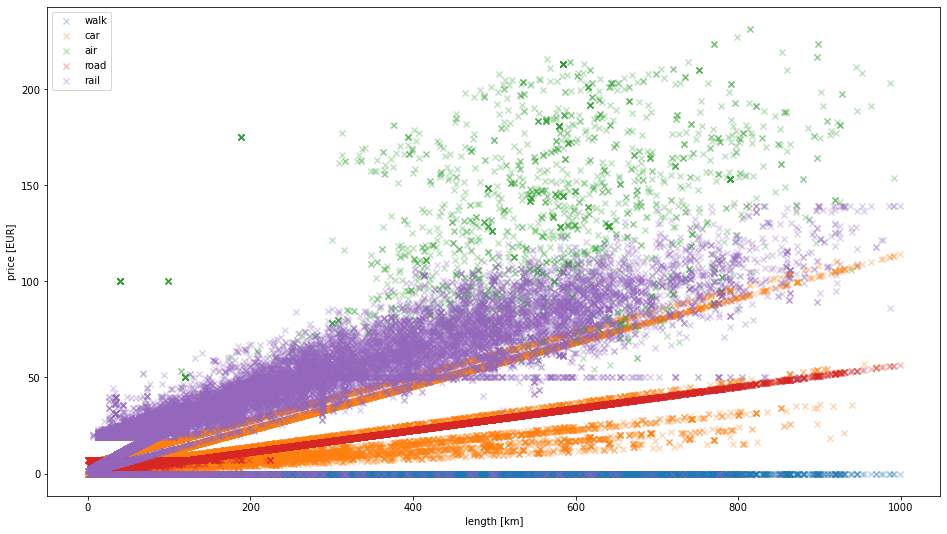

In [160]:
# Show all prices
if manual:
    modes = [#('rail_long', 2), ('rail_short', 1), ('coach',3), ('bus',4),
             ('rail',1), ('road',4), ('air',5), ('car',6), ('walk',7)]
    fig, ax = plt.subplots(figsize=(16,9))
    for m, i in modes[::-1]:
        t = trips#.loc[trips['mode_model']==i].copy()
        plt.scatter(t['length'], t['cost_'+m], marker='x', alpha=.3, label=m)
    plt.legend()
    ax.set_xlabel('length [km]')
    ax.set_ylabel('price [EUR]')

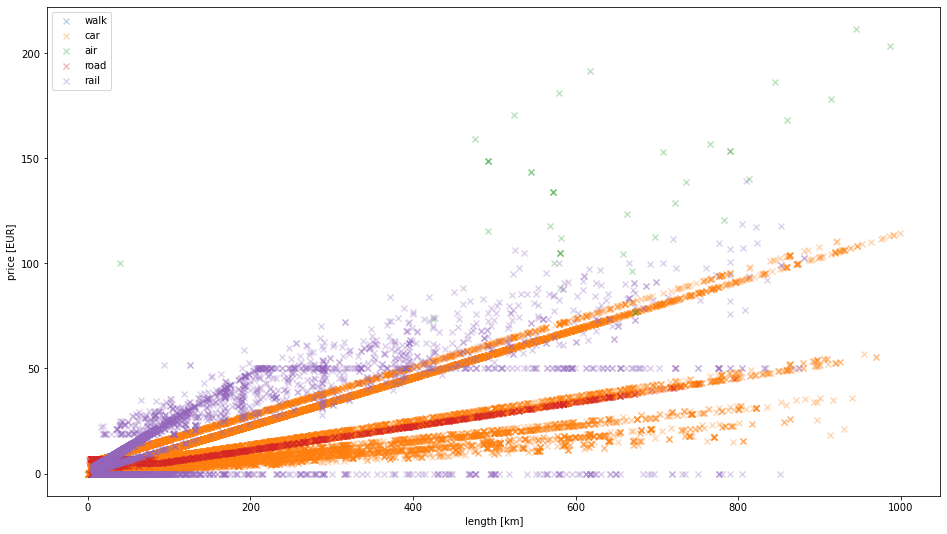

In [161]:
# Show only prices of the mode chosen
if manual:
    modes = [('rail',[1,2]), ('road',[3,4]), ('air',[5]), ('car',[6]), ('walk',[7])]
    fig, ax = plt.subplots(figsize=(16,9))
    for m, i in modes[::-1]:
        t = trips.loc[trips['mode_model'].isin(i)]
        plt.scatter(t['length'], t['cost_'+m], marker='x', alpha=.3, label=m)
    plt.legend()
    ax.set_xlabel('length [km]')
    ax.set_ylabel('price [EUR]')

## Save calibration dataset

In [162]:
trips.drop(['length_routed', 'distance_routed_2'], axis=1, errors='ignore', inplace=True)

In [163]:
assert len(trips.loc[trips.isna().any(axis=1)])==0

In [164]:
trips.to_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')